# Generate synthetic lightcurves
Sample from parameters of all 78 Gaussian Processes to generate synthetic lightcurves.


Add uncorrelated noise by:
   - Fit GP to each lightcurve
   - Define distribution over GP parameters
   - Create histogram of residuals (how many of each amplitude)
   - Define cutoff as 3 sigma
   - Add all cutoff 'tails' to create an 'average' noise distribution

In [2]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import torch
import gpytorch
import matplotlib.pyplot as plt

from dipper.data_utils.utils import *
from dipper.model_utils.gp_model import train_gp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## Single lightcurve

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


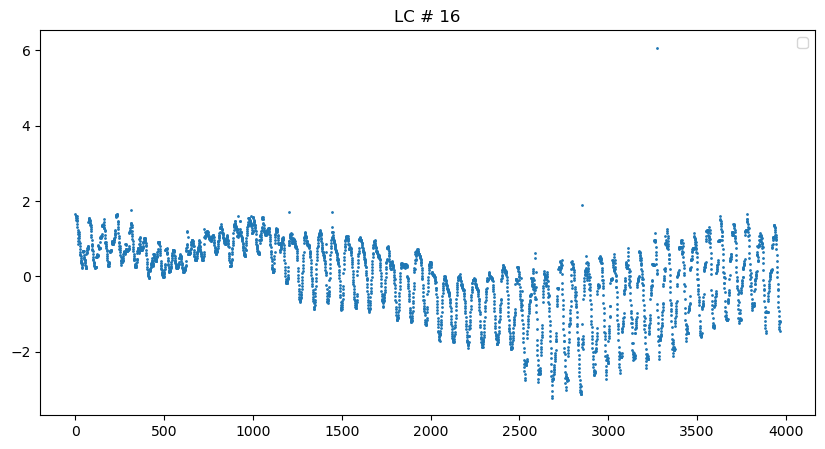

In [57]:
# Load the data
file_number = 16
data_dir = '../../data/k2/'
filename = f'k2_{file_number}.fits'
x, y, y_err = load_k2_data(data_dir + filename)

# Scale data to be between 0 and 1
y = (y - np.min(y)) / (np.max(y) - np.min(y))
y_err = y_err / (np.max(y) - np.min(y))

# Standardize data to have mean 0 and std of 1
mean_y = np.mean(y)
std_y = np.std(y)
y = (y - mean_y) / std_y
y_err = y_err / std_y

# Plot anomalies
plt.figure(figsize=(10,5))
plt.plot(range(len(x)), y, '.', markersize=2)
plt.legend()
plt.title(f"LC # {file_number}")
plt.show()

Fit GP and get model parameters

In [58]:
# Hyperparameters
initial_lengthscale = 0.7
training_iterations = 50
learn_additional_noise = True

# Train GP model
model, likelihood, mll = train_gp(
    torch.tensor(x, dtype=torch.float32).to(device),
    torch.tensor(y, dtype=torch.float32).to(device), 
    torch.tensor(y_err, dtype=torch.float32).to(device), 
    training_iterations=training_iterations, 
    lengthscale=initial_lengthscale, 
    device=device,
    learn_additional_noise=learn_additional_noise
)

In [59]:
# Print learned GP parameters
for name, param in model.named_parameters():
    print(f"{name}: {param.data}")

noises = model.likelihood.noise.squeeze().detach().cpu().numpy()
period_length = model.covar_module.base_kernel.periodic_kernel.period_length.item()
periodic_lengthscale = model.covar_module.base_kernel.periodic_kernel.lengthscale.item()
lengthscale = model.covar_module.base_kernel.rbf_kernel.lengthscale.item()
outputscale = model.covar_module.outputscale.item()
mean_constant = model.mean_module.constant.item()

print("\nLearned GP parameters:")
print("Period Length: ", period_length)
print("Periodic Lengthscale: ", periodic_lengthscale)
print("Lengthscale: ", lengthscale)
print("Outputscale: ", outputscale)
print("Mean Constant: ", mean_constant)
print("Additional Noise: ", noises)

likelihood.second_noise_covar.raw_noise: tensor([-0.1000], device='cuda:0')
mean_module.raw_constant: 0.09998688846826553
covar_module.raw_outputscale: 0.09999995678663254
covar_module.base_kernel.periodic_kernel.raw_lengthscale: tensor([[0.1000]], device='cuda:0')
covar_module.base_kernel.periodic_kernel.raw_period_length: tensor([[0.1000]], device='cuda:0')
covar_module.base_kernel.rbf_kernel.raw_lengthscale: tensor([[-0.0863]], device='cuda:0')

Learned GP parameters:
Period Length:  0.7443966269493103
Periodic Lengthscale:  0.7443966865539551
Lengthscale:  0.6509082317352295
Outputscale:  0.7443966269493103
Mean Constant:  0.09998688846826553
Additional Noise:  [0.64459676 0.64459676 0.64459676 ... 0.64459676 0.64459676 0.64459676]


Evaluate model and find deviant tail distribution

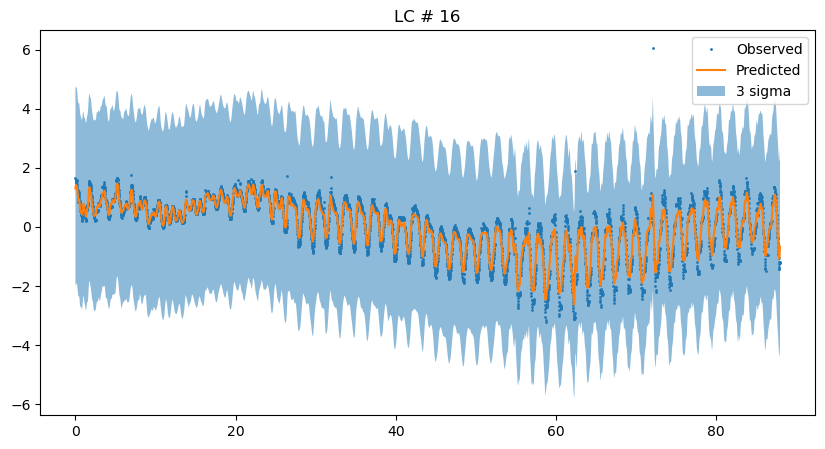

In [60]:
# Predict
model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictions = likelihood(model(torch.tensor(x, dtype=torch.float32).to(device)))
    mean = predictions.mean.cpu().numpy()
    variance = predictions.variance.cpu().numpy()
    stddev = np.sqrt(variance)

# Plot
plt.figure(figsize=(10,5))
plt.plot(x, y, '.', markersize=2, label='Observed')
plt.plot(x, mean, label='Predicted')
plt.fill_between(x, mean - 3*stddev, mean + 3*stddev, alpha=0.5, label='3 sigma')
plt.legend()
plt.title(f"LC # {file_number}")
plt.show()

Number of high residuals: 1


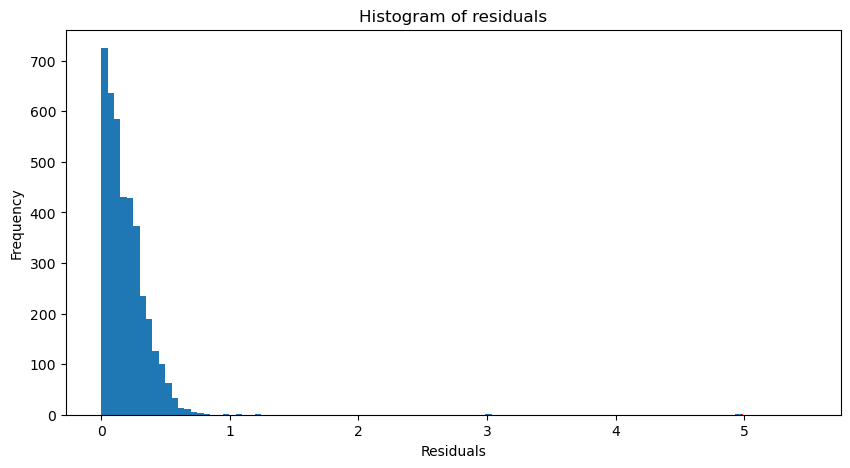

In [ ]:
# Calculate residuals
residuals = np.abs((mean - y))
high_residuals = residuals[residuals > 3*stddev]
print(f"Number of high residuals: {len(high_residuals)}")

# Plot histogram of residuals
plt.figure(figsize=(10,5))
plt.hist(residuals, bins=100)
plt.hist(high_residuals, bins=100, color='red')
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of residuals")
plt.show()

## Create distribution over all 78 lightcurves

In [ ]:
# TODO: See chatGPT for ideas. Use parameters and residuals from above